In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch
import seaborn as sns
from torch import optim
import torch.nn.functional as F

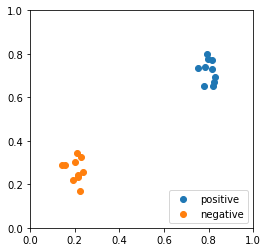

In [52]:
data_x_pos = np.random.multivariate_normal([0.8, 0.7], [[0.001, 0], [0, 0.003]], 10)
data_x_neg = np.random.multivariate_normal([0.2, 0.3], [[0.001, 0], [0, 0.003]], 10)
data_y_pos = np.ones(10)
data_y_neg = np.zeros(10)
data_x = np.vstack([data_x_pos, data_x_neg])
data_y = np.hstack([data_y_pos, data_y_neg])
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(data_x_pos[:,0], data_x_pos[:,1], label='positive')
plt.scatter(data_x_neg[:,0], data_x_neg[:,1], label='negative')
ax.legend(loc='lower right')
ax.set_xlim((0,1))
ax.set_ylim((0,1))

data_x = torch.from_numpy(data_x).float()
data_y = torch.from_numpy(data_y).float()

In [49]:
ax.get_legend_handles_labels()

([], [])

In [21]:
# data_x = np.random.multivariate_normal([0.8, 0.7], [[0.001, 0], [0, 0.003]], 10)
# data_y = np.ones(10)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.scatter(data_x[:,0], data_x[:,1])
# ax.set_xlim((0,1))
# ax.set_ylim((0,1))
# data_x = torch.from_numpy(data_x).float()
# data_y = torch.from_numpy(data_y).float()

In [37]:
class QuadraticKernel(nn.Module):

  def forward(self, input):
    return torch.cat([input, input*input], dim=1)

class ReLog(nn.Module):

  def forward(self, input):
    return torch.log(F.relu(input) + 1)

def plot_model(model):
  val_x = np.linspace(0, 1, 100)
  val_y = np.linspace(0, 1, 100)
  val_x, val_y = np.meshgrid(val_x, val_y)
  input = np.stack([val_x.flatten(), val_y.flatten()], axis=-1)
  val_z = model(torch.from_numpy(input).float()).detach().numpy().reshape(val_x.shape)
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.contourf(val_x, val_y, val_z, 10, cmap=plt.cm.bone, origin='lower')

def demo_model(regularization=lambda m: 0, use_quadratic_kernel=False, n_epochs=100, lr=0.1):
  if use_quadratic_kernel:
    model = nn.Sequential(
        QuadraticKernel(),
        nn.Linear(4, 1),
        nn.ReLU(),
        ReLog()
    )
    linear_module = model[1]
    # with torch.no_grad():
    #   linear_module.weight[:,:2].abs_() # make sure that the model learn
    #   linear_module.weight[:,2:].abs_().neg_()
  else:
    model = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        ReLog()
    )
    linear_module = model[0]
    with torch.no_grad():
      linear_module.weight.abs_() # make sure that the model learn
  # train
  lr = 0.5
  loss_func = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(n_epochs):
      optimizer.zero_grad()
      pred = model(data_x)
      loss = loss_func(pred.flatten(), data_y) + regularization(linear_module)
      loss.backward()
      optimizer.step()
      # print(loss.item())
  # acc = ((pred-0.5)*(data_y-0.5) >= 0).float().mean().item()
  # print('Accuracy:', acc)
  # print(pred, data_y)
  plot_model(model)
  return model

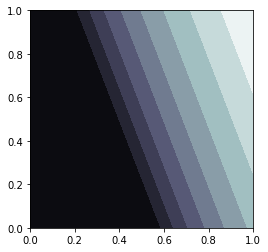

In [38]:
model = demo_model(lambda m: 0)

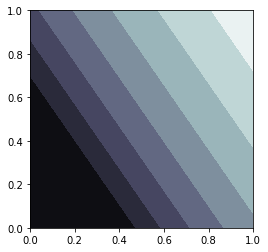

In [65]:
max_margin = lambda m: 0.01*(m.weight*m.weight).mean()
model_reg = demo_model(max_margin)

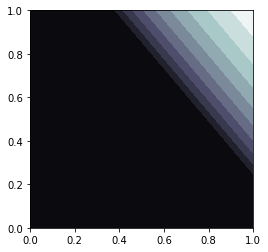

In [42]:
class MaxFitL2(object):
  def __init__(self, alpha=0.02, beta=0.1):
    self.alpha = alpha
    self.beta = beta
  def __call__(self, m):
    return self.alpha*(m.weight*m.weight).mean() + self.beta*m.bias.mean()

model_reg = demo_model(MaxFitL2(alpha=0.03, beta=0.2))

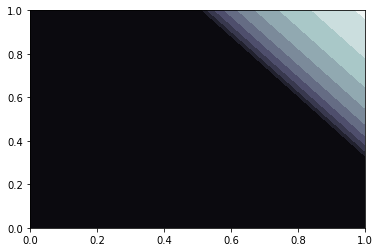

In [ ]:
class MaxFitL1(object):
  def __init__(self, alpha=0.01, beta=0.1):
    self.alpha = alpha
    self.beta = beta
  def __call__(self, m):
    return self.alpha*(m.weight.abs()).mean() + self.beta*m.bias.mean()

model_reg = demo_model(MaxFitL1())

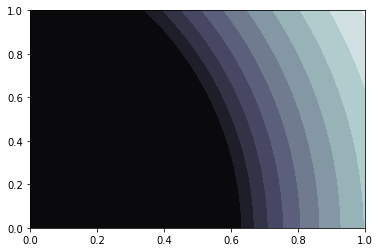

In [ ]:
model = demo_model(use_quadratic_kernel=True)

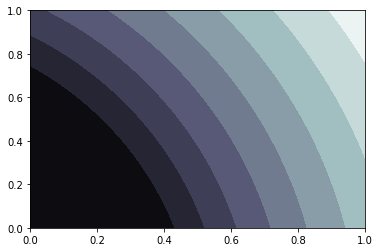

In [ ]:
model = demo_model(max_margin, use_quadratic_kernel=True)

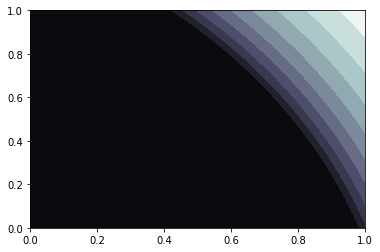

In [ ]:
model = demo_model(MaxFitL2(0.01, 0.05), use_quadratic_kernel=True)

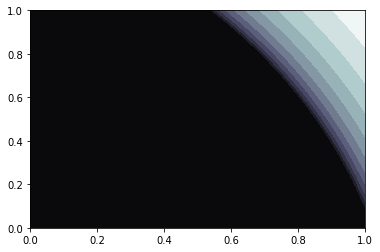

In [ ]:
model = demo_model(MaxFitL1(0.01, 0.3), use_quadratic_kernel=True)

# More negative samples

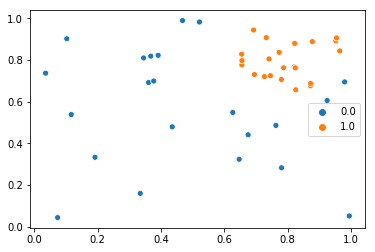

In [ ]:
n = 200
data_x = np.random.rand(n, 2)
data_y = np.zeros(n)
x1, x2 = data_x[:,0], data_x[:,1]
f = np.sqrt((x1-0.8)**2 + (x2-0.8)**2) - 0.2
neg_indices, = (f > 0).nonzero()
pos_indices, = (f < 0).nonzero()
neg_indices = neg_indices[:len(pos_indices)]
data_y[f < 0] = 1
data_x = np.vstack([data_x[neg_indices], data_x[pos_indices]])
data_y = np.hstack([data_y[neg_indices], data_y[pos_indices]])
sns.scatterplot(data_x[:,0], data_x[:,1], hue=data_y)
data_x = torch.from_numpy(data_x).float()
data_y = torch.from_numpy(data_y).float()

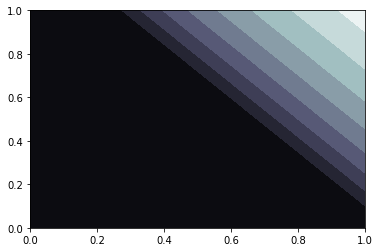

In [ ]:
model = demo_model()

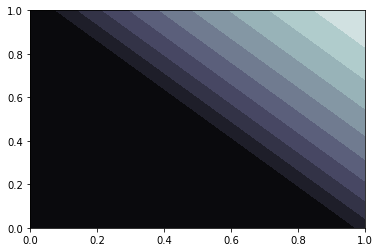

In [ ]:
model_reg = demo_model(max_margin)

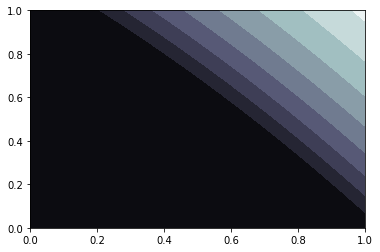

In [ ]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150)

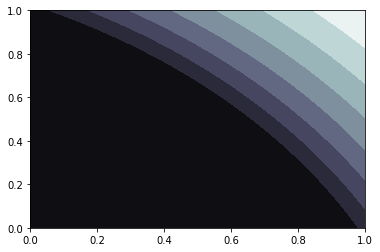

In [ ]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150, regularization=max_margin)

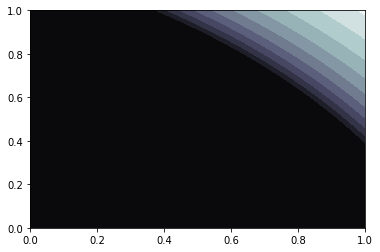

In [ ]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150, regularization=MaxFitL2())

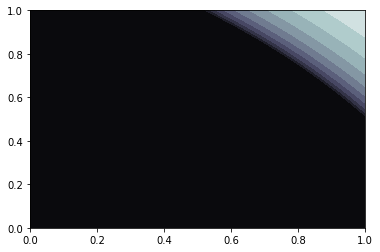

In [ ]:
model = demo_model(use_quadratic_kernel=True, n_epochs=150, regularization=MaxFitL1())